In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


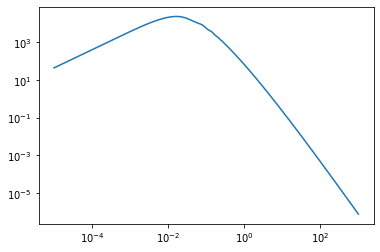

In [2]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=32
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()
flux_true = exp(-uni.final_tau_RSD)[0]

(32, 32, 32)
32768 65 32768
Total run time 4.169994831085205


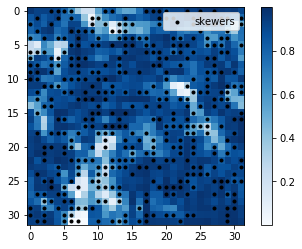

In [4]:
n_los = 400
mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

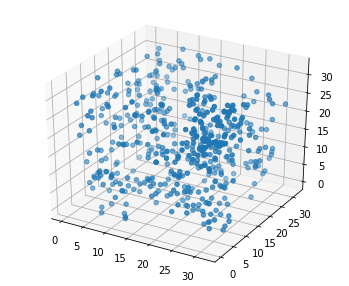

In [5]:
a = 8
mock_gal = gal_survey(uni,a*a) #inverse number density
mock_gal.select_galaxies() #selects galaxies

loc = mock_gal.samples_n #invidual Galaxy locations
fig=figure(figsize=(6,5))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(loc[:,0],loc[:,1],loc[:,2])

In [6]:
def tf_wiener_kernel(mock_lya):
    
    data_coords = tf.constant(mock_lya.skewers_fin,dtype=tf.float32)
    d = mock_lya.vals_observed
    sigma2 = np.cov(d)
    d_los = n/np.sqrt(n_los)

    d = tf.constant(d,shape=(len(d),1),dtype=tf.float32)
    map_x,map_y,map_z = meshgrid(arange(0,n),arange(0,n),arange(0,n))
    map_coords = tf.constant(np.vstack(list(map(np.ravel, [map_x,map_y,map_z]))).T,dtype=tf.float32)

    L_para = d_los
    L_prep = d_los

    m_1 = tf.reshape(map_coords[:,0],(-1,1))
    d_1 = tf.reshape(data_coords[:,0],(-1,1))
    m_2 = tf.reshape(map_coords[:,1],(-1,1))
    d_2 = tf.reshape(data_coords[:,1],(-1,1))
    m_3 = tf.reshape(map_coords[:,2],(-1,1))
    d_3 = tf.reshape(data_coords[:,2],(-1,1))

    with tf.device('/cpu:0'):
        d_1_matrix1 = tf.tile(d_1,[1,d_1.shape[0]])
        d_1_matrix2 = tf.transpose(d_1_matrix1)

        d_2_matrix1 = tf.tile(d_2,[1,d_2.shape[0]])
        d_2_matrix2 = tf.transpose(d_2_matrix1)

        d_3_matrix1 = tf.tile(d_3,[1,d_3.shape[0]])
        d_3_matrix2 = tf.transpose(d_3_matrix1)

        r_prep = (d_1_matrix1-d_1_matrix2)**2+(d_2_matrix1-d_2_matrix2)**2
        r_para = (d_3_matrix1-d_3_matrix2)**2

        C_DD = sigma2*tf.exp(-r_para/L_para**2)*tf.exp(-r_prep/L_para**2)

        m_1_matrix = tf.tile(m_1,[1,d_1.shape[0]])
        d_1_matrix = tf.transpose(tf.tile(d_1,[1,m_1.shape[0]]))

        m_2_matrix = tf.tile(m_2,[1,d_2.shape[0]])
        d_2_matrix = tf.transpose(tf.tile(d_2,[1,m_2.shape[0]]))

        r_prep = (m_1_matrix-d_1_matrix)**2+(m_2_matrix-d_2_matrix)**2

        m_3_matrix = tf.tile(m_3,[1,d_3.shape[0]])
        d_3_matrix = tf.transpose(tf.tile(d_3,[1,m_3.shape[0]]))

        r_para = (m_3_matrix-d_3_matrix)**2

        C_MD = sigma2*tf.exp(-r_para/L_para**2)*tf.exp(-r_prep/L_para**2)

        N_inv = mock_lya.inverse_covar
        N = tf.sparse.SparseTensor(N_inv.indices,1/N_inv.values,N_inv.dense_shape)
        N = tf.sparse.to_dense(N)

        mat_inv = tf.matrix_inverse(C_DD+N)
        kernel = tf.matmul(C_MD,mat_inv)
        
    sess = tf.Session()
    k = sess.run(kernel)
    return k

In [7]:
wiener_kernel = tf_wiener_kernel(mock_lya)

In [8]:
flux_obs = mock_lya.vals_observed
flux_contrast = flux_obs/flux_obs.mean()-1
flux_wiener_recon = reshape((np.dot(wiener_kernel,flux_contrast)+1)*flux_obs.mean(),(n,n,n))
flux_wiener_recon=array([flux_wiener_recon[:,i,:] for i in range(n)])

In [9]:
d_los = n/(n_los)**0.5
d_los

1.6

In [10]:
lya_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal, specz_fac=0.0,lya_fac=1.0,pk_fac=0,anneal_steps=[4,3,2,1,0],maxiter=[10,10,10,10,10])  
lya_recon.initmodel()
lya_recon.run_model()


(32, 32, 32)
32768 65 32768
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
r0,  4
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 143623.218750
  Number of iterations: 10
  Number of functions evaluations: 13
Run Time:  6.568087816238403
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 141915.390625
  Number of iterations: 10
  Number of functions evaluations: 14
Run Time:  12.750318765640259
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 138992.734375
  Number of iterations: 10
  Number of functions evaluations: 14
Run Time:  19.83832049369812
r0,  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function val

In [11]:
pk_fac = 0.0
print("### Galaxies + Lyman Alpha ###")
joint_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal,specz_fac=0.0,specz_L2=False,lya_fac=1.,pk_fac=pk_fac,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20])  #initializing with equal weight on galaxy field and lyman alpha field
joint_recon.initmodel() #initialize model
joint_recon.run_model() #run optimization

print("### Galaxies Only ###")
gal_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal,specz_L2=True,specz_fac=1000.0,lya_fac=0.0,pk_fac=pk_fac,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20]) 
gal_recon.initmodel() #initialize model
gal_recon.run_model() #run optimization

### Galaxies + Lyman Alpha ###
(32, 32, 32)
32768 65 32768
r0,  5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 144663.562500
  Number of iterations: 5
  Number of functions evaluations: 10
Run Time:  6.0614752769470215
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 142704.671875
  Number of iterations: 5
  Number of functions evaluations: 8
Run Time:  12.323544979095459
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 139575.484375
  Number of iterations: 5
  Number of functions evaluations: 8
Run Time:  18.340308666229248
r0,  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 89741.226562
  Number of iterations: 20
  Number of functions e

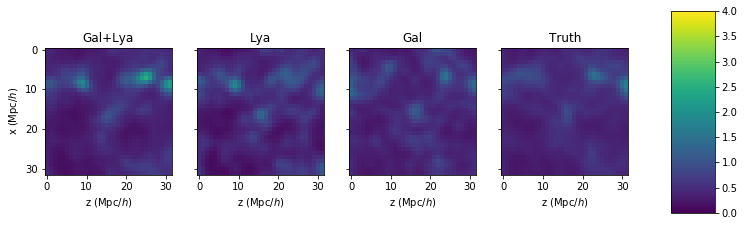

In [12]:
ax = 0
sm = 1.0

f, axis = plt.subplots(1, 4, sharey='row',figsize=(12.0, 4.0))

axis[0].imshow(ndimage.gaussian_filter(joint_recon.uni_rec.final_true[0],sm).sum(axis=ax)/64,vmin=0,vmax=4.0)
axis[0].set_title("Gal+Lya")
axis[0].set_xlabel("z (Mpc/$h$)")
axis[0].set_ylabel("x (Mpc/$h$)")

axis[1].imshow(ndimage.gaussian_filter(lya_recon.uni_rec.final_true[0],sm).sum(axis=ax)/64,vmin=0,vmax=4.0)
axis[1].set_title("Lya")
axis[1].set_xlabel("z (Mpc/$h$)")

axis[2].imshow(ndimage.gaussian_filter(gal_recon.uni_rec.final_true[0],sm).sum(axis=ax)/64,vmin=0,vmax=4.0)
axis[2].set_title("Gal")
axis[2].set_xlabel("z (Mpc/$h$)")

im = axis[3].imshow(ndimage.gaussian_filter(uni.final_true[0],sm).sum(axis=ax)/64,vmin=0,vmax=4.0)
axis[3].set_title("Truth")
axis[3].set_xlabel("z (Mpc/$h$)")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax,)

In [13]:
flux_tardis_recon = exp(-lya_recon.recon_RSD_tau)[0]

### Optimization

Let N be the noise covariance, $S_m$ be the smoothing operator, s is the reconstructed flux field, d is the data, R is the mapping from flux field to data space, and $k_1,k_2,k_3$ are weighting coefficents. 

The quantity to be optimized:
$$\chi^2 = k_1(S_m(s) - s)^2 + k_2(R(s) - d)^T N^{-1} (R(s)-d)+k_3\sum clip(s,1,+\infty)$$
**Note** that I added the third term to clip flux values and sum them up which penalizes optimization for flux values over one. It later shows that we can get better reconstruction with it.

In [14]:
def loss(inputs, data, inverse_covar):
    
    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):
    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def opt_recon(mock_lya,k1=2,k2=2,k3=1,clip=True,anneal_steps=[2.5,1.5,1,0.7],maxiter=[50,50,60,30]):
    tf.reset_default_graph()
    lya=mock_lya

    initial=tf.Variable(zeros(shape=(1,n,n,n)),dtype='float32',trainable=True)
    RSD_tau = tf.multiply(initial,1)

    Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
    sum_op = reduce_sum_det

    Rsm = tf.multiply(Rs, 1)
    kvec = fftk((n,n,n), symmetric=False)
    kmesh = __builtin__.sum((np.array(kvec,dtype=object))**2)**0.5
    pkmesh = ipklin(kmesh)

    flux = tf.exp(-RSD_tau)
    flux_s = smoothing(flux,Rsm,kmesh,n)
    yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
    flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

    #The final loss functon we want to minimize
    if clip:
        obj_fun = k1*(loss(flux_val,yy_lya,lya.inverse_covar)+k2*sum_op(tf.square(tf.subtract(flux_s,flux)))
                   +k3*overone(flux))
    else:
        obj_fun = k1*(loss(flux_val,yy_lya,lya.inverse_covar)+k2*sum_op(tf.square(tf.subtract(flux_s,flux))))
               
    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    gtol=1e-5/512
    anneal_steps = [2.5,1.5,1,0.7]
    maxiter = [50,50,60,30]

    time_start = time.time()
    for nn,r0 in enumerate(anneal_steps):
        opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': False})
        z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
    time_end = time.time()
    print('Total run time %f'%(time_end-time_start))
#     recon_RSD_tau,recon_flux = sess.run([RSD_tau,flux_val],{yy_lya:lya.vals_observed,Rs:[0]})
    recon_RSD_tau= sess.run(RSD_tau,{yy_lya:lya.vals_observed,Rs:[0]})
    return recon_RSD_tau
#     return recon_RSD_tau,recon_flux

Let's compare how the third clip loss term influence our optimization.

In [106]:
tau_opt_recon_clip = opt_recon(mock_lya,1,3,2,clip=True)
flux_opt_recon_clip = exp(-tau_opt_recon_clip[0])

tau_opt_recon_no_clip = opt_recon(mock_lya,1,3,2,clip=False)
flux_opt_recon_no_clip = exp(-tau_opt_recon_no_clip[0])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 79981.625000
  Number of iterations: 11
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 79668.195312
  Number of iterations: 50
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 79212.554688
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 78530.125000
  Number of iterations: 30
  Number of functions evaluations: 32
Total run time 3.379192
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function val

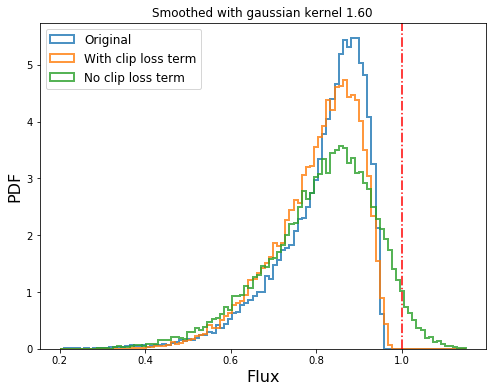

In [107]:
sigma=1*d_los
bins=linspace(0.2,1.15,100)
fig = figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon_clip,sigma).flatten(),label='With clip loss term',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon_no_clip,sigma).flatten(),label='No clip loss term',**h_list)
legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('Smoothed with gaussian kernel %.2f'%sigma)
axvline(1,color='red',linestyle='-.')
show()

We could notice that a considerable part of the flux values exceed 1 if the optimization doesn't have the clip loss term, while the optimization with clip loss term has a better profile which is rather close to the true distribution.

But how about clipping the flux after the optimization without the clip loss term?

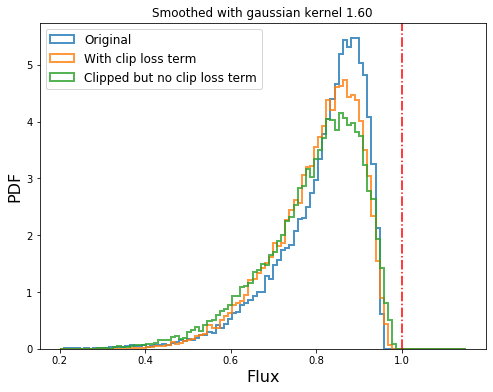

In [108]:
flux_after_clip = clip(flux_opt_recon_no_clip,0,1)

sigma=1*d_los
bins=linspace(0.2,1.15,100)
fig = figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon_clip,sigma).flatten(),label='With clip loss term',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_after_clip,sigma).flatten(),label='Clipped but no clip loss term',**h_list)
legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('Smoothed with gaussian kernel %.2f'%sigma)
axvline(1,color='red',linestyle='-.')
show()

Clipping the flux after the optimization without the clip loss term does dispose the outlying values, but the shape of the profile is however biased to lower flux.

Thus we can find that adding the clip loss term isn't simply clipping all the values over one, but it can influence the overall profile of our reconstructed flux.

In all later analysis, the gaussian kernel is fixed at $\sigma=<d_{LOS}>=1.6 h^{-1}Mpc$ when the fields are smoothed. Some paper used $\sigma=1.4<d_{LOS}>$, but I found $\sigma=<d_{LOS}>$ provides better result here.

In [109]:
flux_opt_recon = flux_opt_recon_clip

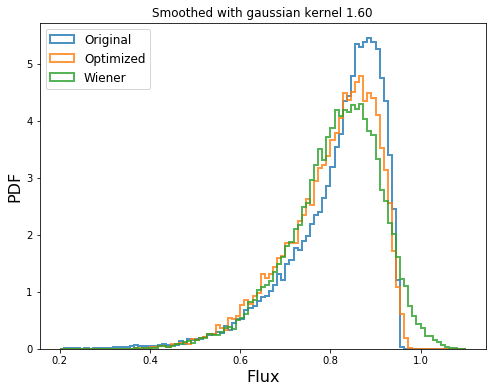

In [113]:
sigma=1*d_los
bins=linspace(0.2,1.1,100)
fig = figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon,sigma).flatten(),label='Optimized',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_wiener_recon,sigma).flatten(),label='Wiener',**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('Smoothed with gaussian kernel %.2f'%sigma)

show()

Show the slices of unsmoothed flux field projected over 4 $h^{-1}Mpc$ perpendicular to LOSs.

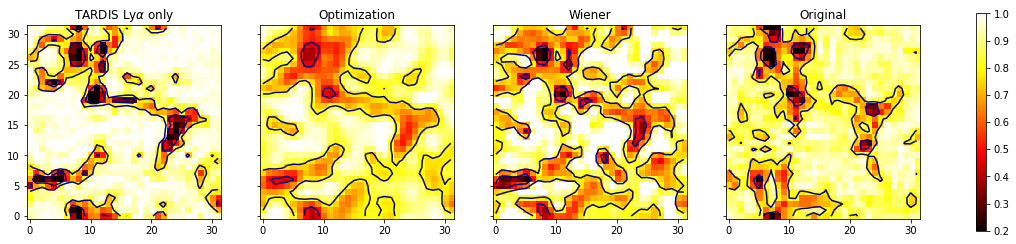

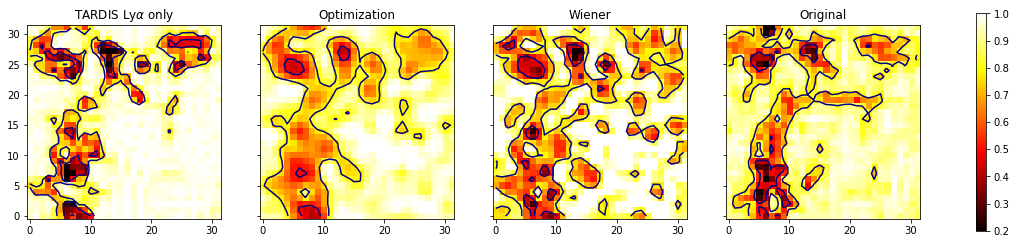

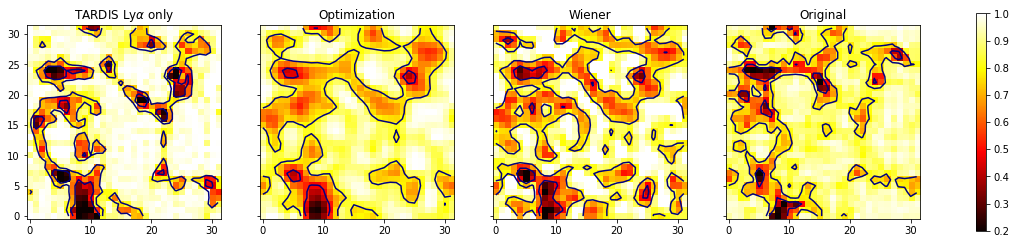

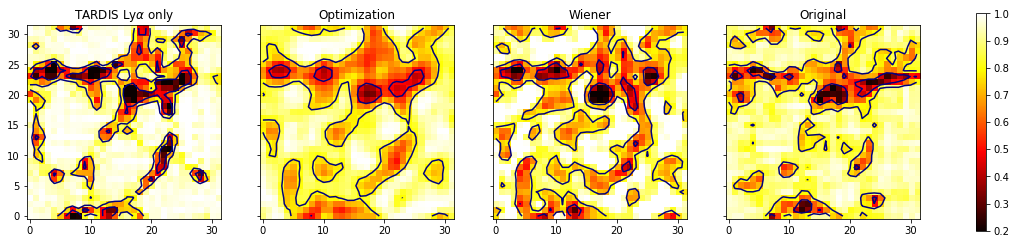

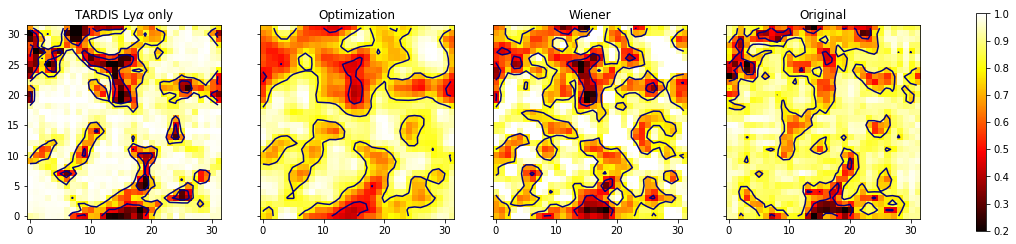

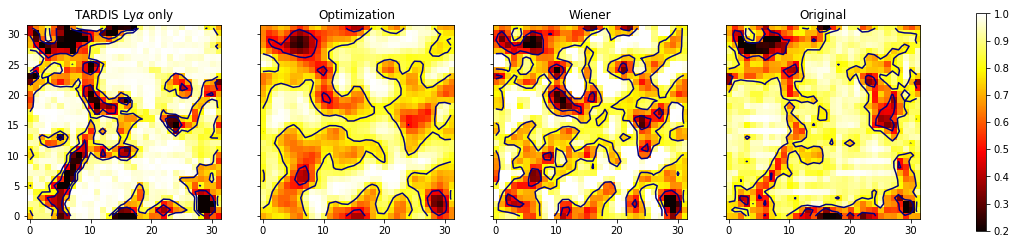

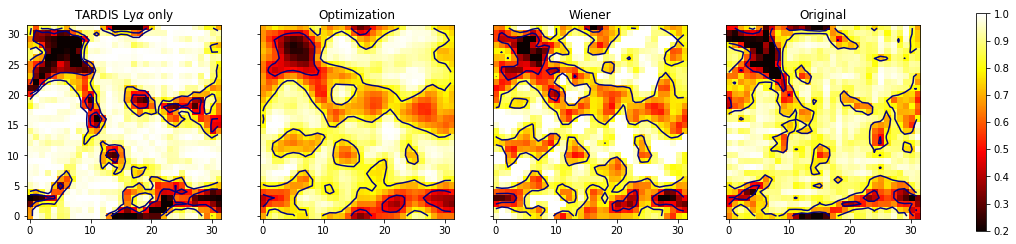

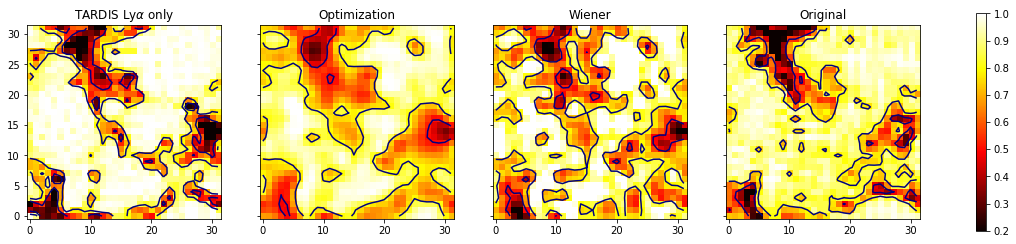

In [114]:
plot_list = {'vmin':0.2,'vmax':1,'cmap':"hot",'origin':'lower'}
con_list = {'levels':[0.5,0.8],'colors':'navy'}

for i in range(n//4):
    fig, ax = plt.subplots(1, 4, sharey='row',figsize=(20,4))

    im1 = ax[0].imshow(flux_tardis_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[0].contour(flux_tardis_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[0].set_title(r'TARDIS Ly$\alpha$ only')

    im2 = ax[1].imshow(flux_opt_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[1].contour(flux_opt_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[1].set_title('Optimization')

    im3 = ax[2].imshow(flux_wiener_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[2].contour(flux_wiener_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[2].set_title('Wiener')
    
    im4 = ax[3].imshow(flux_true[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    con = ax[3].contour(flux_true[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[3].set_title('Original')
    colorbar(im4,ax=ax)
show()


Show the slices of flux field smoothed with gaussain kernel $\sigma=<d_{LOS}>=1.6h^{-1}Mpc$ and projected over 4 $h^{-1}Mpc$ perpendicular to LOSs.

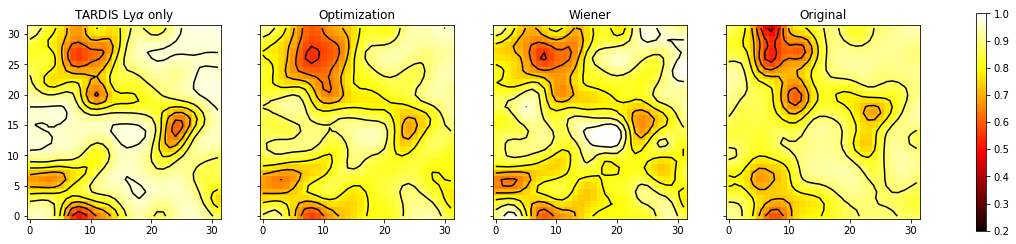

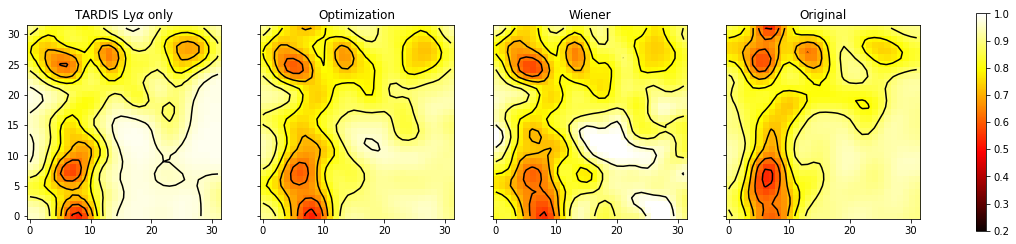

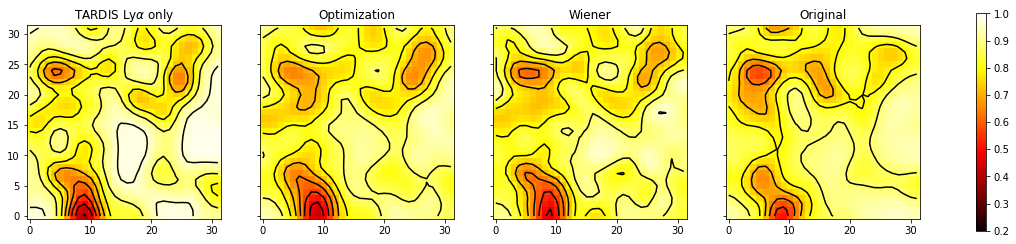

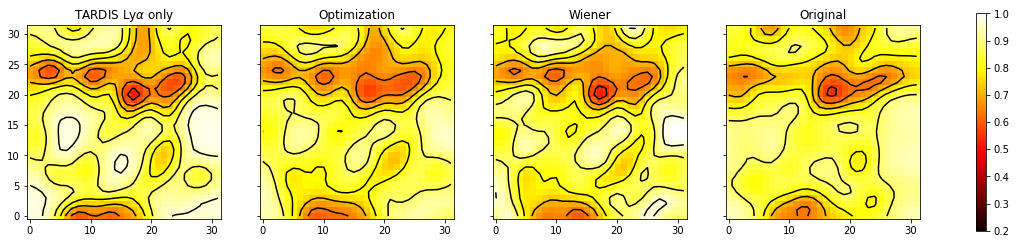

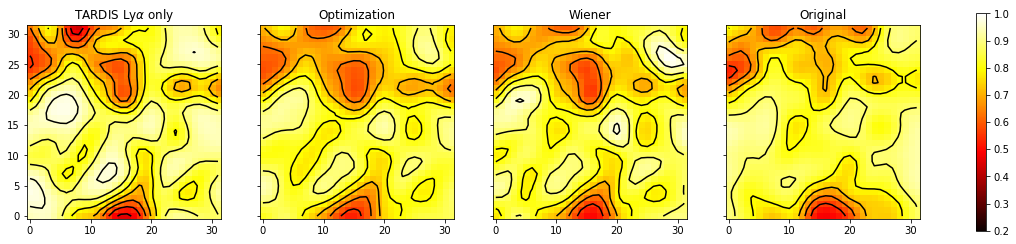

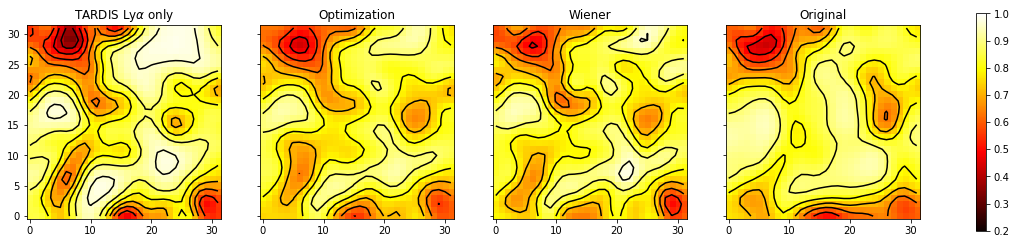

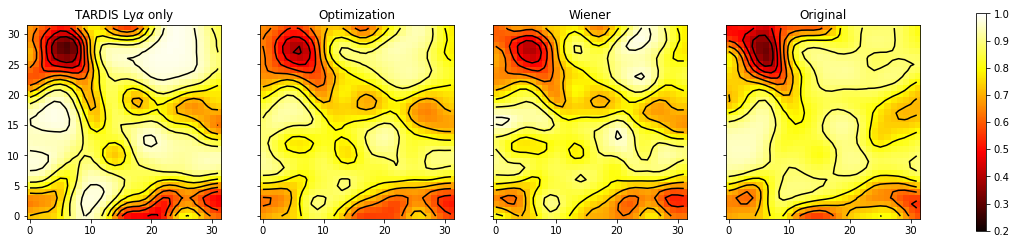

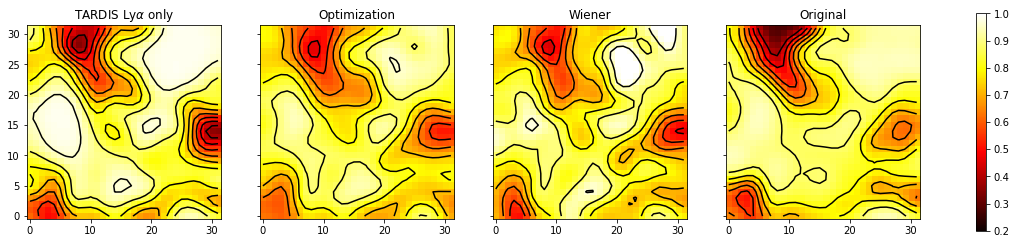

In [115]:
sigma=d_los
plot_list = {'vmin':0.2,'vmax':1,'cmap':"hot",'origin':'lower'}
con_list = {'levels':array([0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88, 0.96]),'colors':'black'}

tardis_sm = ndimage.gaussian_filter(flux_tardis_recon,sigma)
opt_sm = ndimage.gaussian_filter(flux_opt_recon,sigma)
wiener_sm = ndimage.gaussian_filter(flux_wiener_recon,sigma)
true_sm=ndimage.gaussian_filter(flux_true,sigma)

for i in range(n//4):
    fig, ax = plt.subplots(1, 4, sharey='row',figsize=(20,4))

    im1 = ax[0].imshow(tardis_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[0].contour(tardis_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[0].set_title(r'TARDIS Ly$\alpha$ only')

    im2 = ax[1].imshow(opt_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[1].contour(opt_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[1].set_title('Optimization')

    im3 = ax[2].imshow(wiener_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[2].contour(wiener_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[2].set_title('Wiener')
    
    im4 = ax[3].imshow(true_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[3].contour(true_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[3].set_title('Original')
    colorbar(im4,ax=ax)
show()

In [116]:
res_opt_sm = opt_sm.flatten()-true_sm.flatten()
res_wiener_sm = wiener_sm.flatten()-true_sm.flatten()
res_tardis_sm = tardis_sm.flatten()-true_sm.flatten()
print('Variance of residual(smoothed):\nOptimization: %.5f\nWiener: %.5f\nTARDIS: %.5f'%(var(res_opt_sm),var(res_wiener_sm),var(res_tardis_sm)))

Variance of residual(smoothed):
Optimization: 0.00306
Wiener: 0.00426
TARDIS: 0.00419


In [117]:
res_opt = flux_opt_recon.flatten()-flux_true.flatten()
res_wiener = flux_wiener_recon.flatten()-flux_true.flatten()
res_tardis = flux_tardis_recon.flatten()-flux_true.flatten()
print('Variance of residual:\nOptimization: %.5f\nWiener: %.5f\nTARDIS: %.5f'%(var(res_opt),var(res_wiener),var(res_tardis)))

Variance of residual:
Optimization: 0.03009
Wiener: 0.06027
TARDIS: 0.05547


In [118]:
res_opt_sum = sum(abs(flux_opt_recon.flatten()-flux_true.flatten()))
res_wiener_sum = sum(abs(flux_wiener_recon.flatten()-flux_true.flatten()))
res_tardis_sum = sum(abs(flux_tardis_recon.flatten()-flux_true.flatten()))
print('Sum of absolute residual:\nOptimization: %.4f\nWiener: %.4f\nTARDIS: %.4f'%(res_opt_sum,res_wiener_sum,res_tardis_sum))

Sum of absolute residual:
Optimization: 4256.9062
Wiener: 6340.1739
TARDIS: 5104.2798


In [119]:
res_opt_sm_sum = sum(abs(opt_sm.flatten()-true_sm.flatten()))
res_wiener_sm_sum = sum(abs(wiener_sm.flatten()-true_sm.flatten()))
res_tardis_sm_sum = sum(abs(tardis_sm.flatten()-true_sm.flatten()))
print('Sum of absolute residual(smoothed):\nOptimization: %.4f\nWiener: %.4f\nTARDIS: %.4f'%(res_opt_sm_sum,res_wiener_sm_sum,res_tardis_sm_sum))

Sum of absolute residual(smoothed):
Optimization: 1407.0233
Wiener: 1654.7130
TARDIS: 1836.3481


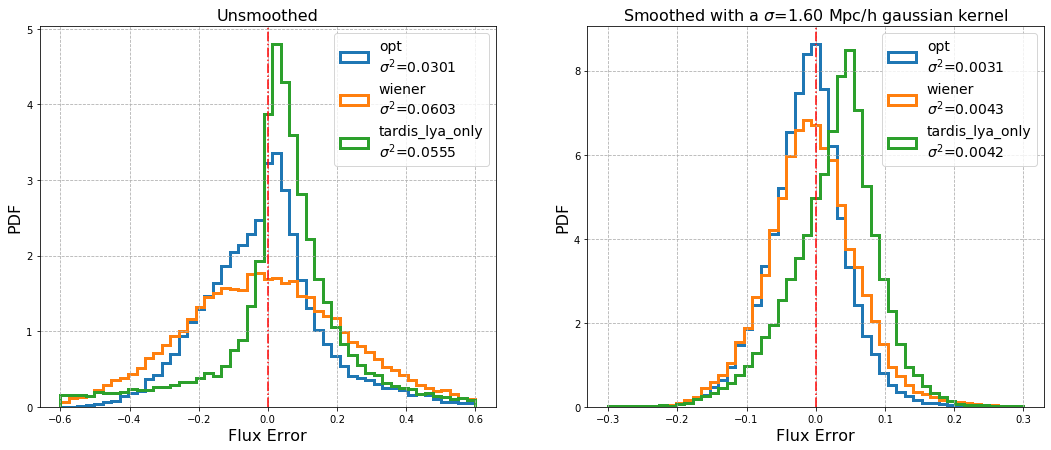

In [120]:
bins = np.linspace(-0.6,0.6,50)
figure(figsize=(18,7))
subplot(121)
h_list = {'bins':bins,'histtype':'step','linewidth':3,'density':True}
_=hist(res_opt,label='opt\n'+r'$\sigma^2$=%.4f'%cov(res_opt),**h_list)
_=hist(res_wiener,label='wiener\n'+r'$\sigma^2$=%.4f'%cov(res_wiener),**h_list)
_=hist(res_tardis,label='tardis_lya_only\n'+r'$\sigma^2$=%.4f'%cov(res_tardis),**h_list)
grid(linestyle='--')
axvline(0,color='red',linestyle='-.')
legend(loc=1,fontsize=14)
xlabel('Flux Error',fontsize=16)
ylabel('PDF',fontsize=16)
title('Unsmoothed',fontsize=16)

subplot(122)
bins = np.linspace(-0.3,0.3,50)
h_list = {'bins':bins,'histtype':'step','linewidth':3,'density':True}
_=hist(res_opt_sm,label='opt\n'+r'$\sigma^2$=%.4f'%cov(res_opt_sm),**h_list)
_=hist(res_wiener_sm,label='wiener\n'+r'$\sigma^2$=%.4f'%cov(res_wiener_sm),**h_list)
_=hist(res_tardis_sm,label='tardis_lya_only\n'+r'$\sigma^2$=%.4f'%cov(res_tardis_sm),**h_list)
legend(loc=1,fontsize=14)
xlabel('Flux Error',fontsize=16)
ylabel('PDF',fontsize=16)
title('Smoothed with a $\sigma$=%.2f Mpc/h gaussian kernel'%sigma,fontsize=16)
grid(linestyle='--')
axvline(0,color='red',linestyle='-.')

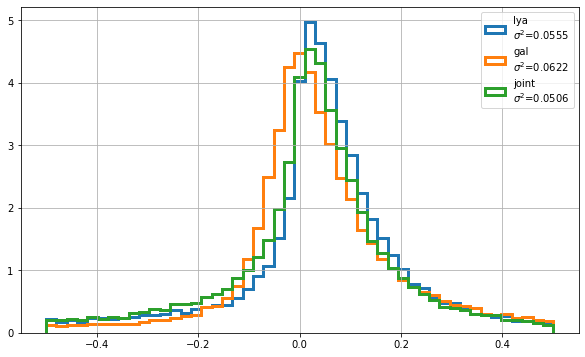

In [122]:
bins = np.linspace(-0.5,0.5,50)
figure(figsize=(10,6))
h_list = {'bins':bins,'histtype':'step','linewidth':3,'density':True}
res_lya = exp(-lya_recon.recon_RSD_tau).flatten()-flux_true.flatten()
res_gal = exp(-gal_recon.recon_RSD_tau).flatten()-flux_true.flatten()
res_joint = exp(-joint_recon.recon_RSD_tau).flatten()-flux_true.flatten()
_=hist(res_lya,label='lya\n'+r'$\sigma^2$=%.4f'%var(res_lya),**h_list)
_=hist(res_gal,label='gal\n'+r'$\sigma^2$=%.4f'%var(res_gal),**h_list)
_=hist(res_joint,label='joint\n'+r'$\sigma^2$=%.4f'%var(res_joint),**h_list)
grid()
legend(loc=1)

In [123]:
# linear regression
def linfit(x,y):
    model = linear_model.LinearRegression()
    permutation=np.random.permutation(len(y))
    X=x[permutation]
    Y=y[permutation]

    a = math.floor(3*len(Y)/4)
    train_X = X[:a].reshape(-1,1)
    train_Y = Y[:a].reshape(-1,1)
    test_X = X[a:].reshape(-1,1)
    test_Y = Y[a:].reshape(-1,1)

    model.fit(train_X,train_Y)
    r=model.score(test_X,test_Y)**0.5
    return model,r

In [155]:
sigma=d_los

x = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0]),sigma).flatten()
y1 = ndimage.gaussian_filter(flux_opt_recon,sigma).flatten()
y2 = ndimage.gaussian_filter(flux_wiener_recon,sigma).flatten()
y3 = ndimage.gaussian_filter(flux_tardis_recon,sigma).flatten()

# fit the data, compute slope k and correlation coefficient r.
m1,r1 = linfit(x,y1)
m2,r2 = linfit(x,y2)
m3,r3 = linfit(x,y3)

linx = array([0.4,1.05]).reshape(-1,1)
k1 = ((m1.predict(linx)[1]-m1.predict(linx)[0])/(linx[1]-linx[0]))[0]
k2 = ((m2.predict(linx)[1]-m2.predict(linx)[0])/(linx[1]-linx[0]))[0]
k3 = ((m3.predict(linx)[1]-m3.predict(linx)[0])/(linx[1]-linx[0]))[0]

Text(0.5, 0, '$Flux_{true}$')

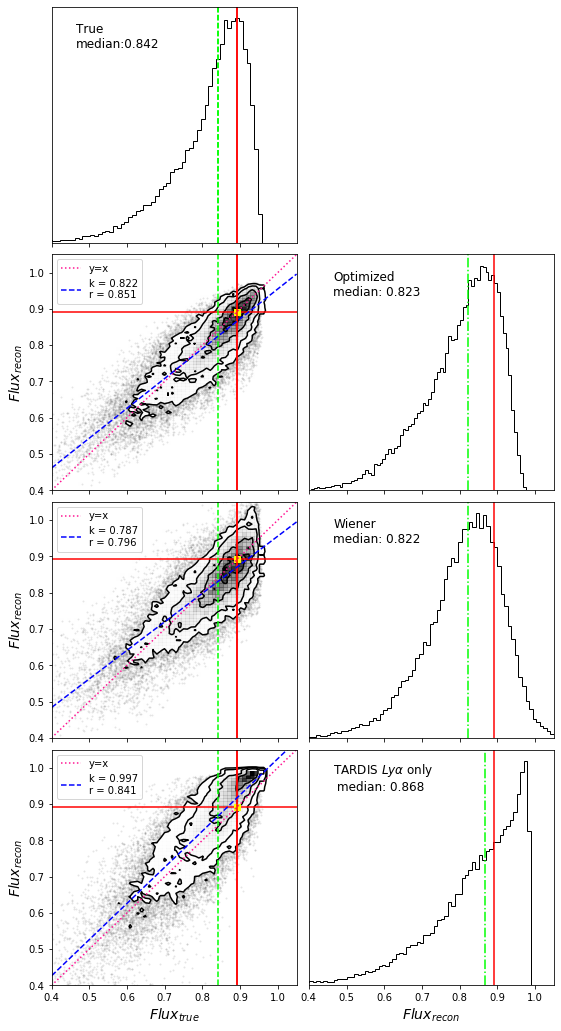

In [157]:
fig,ax = subplots(4,2,figsize=(9,18),sharex='col')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

bins = 80
corner.hist2d(x,y1,ax=ax[1,0],bins=bins)
corner.hist2d(x,y2,ax=ax[2,0],bins=bins)
corner.hist2d(x,y3,ax=ax[3,0],bins=bins)
value,histbin,_= ax[0,0].hist(x,histtype='step',bins=bins,color='k')
_= ax[1,1].hist(y1,histtype='step',bins=bins,color='k')
_= ax[2,1].hist(y2,histtype='step',bins=bins,color='k')
# y3 is the smoothed TARDIS lya only recon
_= ax[3,1].hist(y3,histtype='step',bins=bins,color='k')


a = histbin[where(value==value.max())]+0.5*(histbin[1]-histbin[0])
b=a

q1 = corner.quantile(x,0.5)
q2 = corner.quantile(y1,0.5)
q3 = corner.quantile(y2,0.5)
q4 = corner.quantile(y3,0.5)
q = [q2,q3,q4]

for i in range(4):
    ax[i,1].set_yticks([])
    if i>0:
        ax[i,0].axvline(a,color='red')
        ax[i,0].axhline(b,color='red')
        ax[i,0].set_ylim(0.4,1.05)
        ax[i,0].plot(a,b,'s',c='yellow')
        ax[i,0].set_ylabel(r'$Flux_{recon}$',fontsize=14)
        ax[i,0].plot([0.4,1.05],[0.4,1.05],c='deeppink',linestyle=':',label='y=x')
    for j in range(2):
        ax[i,j].set_xlim(0.4,1.05)
        if j > i:
            ax[i,j].set_frame_on(False)
            ax[i,j].axis('off')
        if (i>0)&(j>0):
            ax[i,j].axvline(a,color='red')
            ax[i,j].axvline(q[i-1],color='lime',linestyle='-.')
        else:
            ax[i,0].axvline(a,color='red')
            ax[i,0].axvline(q1,color='lime',linestyle='--')

ax[1,0].plot(linx,m1.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k1,r1))
ax[1,0].legend()
ax[2,0].plot(linx,m2.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k2,r2))
ax[2,0].legend()
ax[3,0].plot(linx,m3.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k3,r3))
ax[3,0].legend()

ax[0,0].set_yticks([])
ax[0,0].set_title('True\nmedian:%.3f'%q1,x=0.1,y=0.8,loc='left')
ax[1,1].set_title('Optimized\nmedian: %.3f'%q2,x=0.1,y=0.8,loc='left')
ax[2,1].set_title('Wiener\nmedian: %.3f'%q3,x=0.1,y=0.8,loc='left')
ax[3,1].set_title(r'TARDIS $Ly\alpha$ only'+ '\n'+' median: %.3f'%q4,x=0.1,y=0.8,loc='left')
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)
ax[3,1].set_xlabel(r'$Flux_{recon}$',fontsize=14)
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)
# savefig('contour.jpg',dpi=100,bbox_inches='tight')

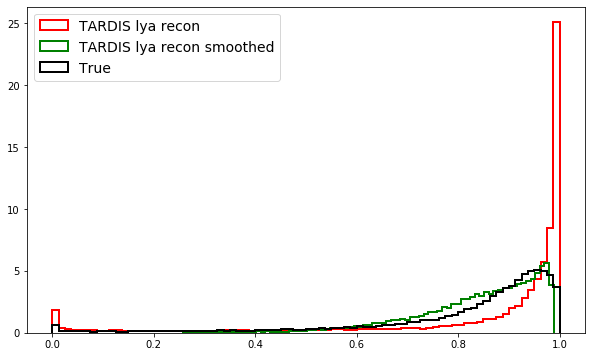

In [161]:
figure(figsize=(10,6))
bins = 80
h_list = {'histtype':'step','bins':bins,'density':True,'linewidth':2}

hist(exp(-lya_recon.recon_RSD_tau[0]).flatten(),color='r',label='TARDIS lya recon',**h_list)
hist(y3,color='g',label='TARDIS lya recon smoothed',**h_list)
hist(exp(-uni.final_tau_RSD[0]).flatten(),color='k',label='True',**h_list)
legend(loc=2,fontsize=14)
show()

In [145]:
y3.max()

0.9784004

From the figure above, we could see that my optimization works pretty good. The modes of reconstructed and true flux values are close and both the slope and correlation coefficient outperform wiener filter's. But as for TARDIS lyman alpha only, the profile is more different to others'.

Then I will compare the density field.

In [126]:
#convert flux to density
def fgpa(flux):
    tau = -np.log(flux)
    return (tau/0.226)**(1/1.5)

In [127]:
density_opt = fgpa(np.clip(flux_opt_recon,0,1))
# flux values equal to 0 will make density as inf and it causes error when plotting histogram
# so I set a small lower limit above 0 for wiener filter. Flux values over also cause error.
density_wiener = fgpa(np.clip(flux_wiener_recon,0.001,1))

Text(0, 0.5, 'PDF')

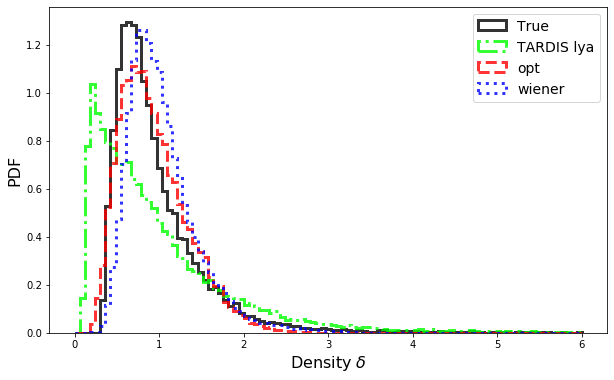

In [128]:
bins = np.linspace(0,6,100)
figure(figsize=(10,6))
sigma=d_los
h_list = {'bins':bins,'histtype':'step','linewidth':3,'alpha':0.8,'density':True}
_=hist(ndimage.gaussian_filter(uni.final_true,sigma).flatten(),label='True',**h_list,color='k')
_=hist(ndimage.gaussian_filter(lya_recon.recon_evolved[0],sigma).flatten(),label='TARDIS lya',**h_list,linestyle='-.',color='lime')
_=hist(ndimage.gaussian_filter(density_opt,sigma).flatten(),label='opt',**h_list,linestyle='--',color='red')
_=hist(ndimage.gaussian_filter(density_wiener,sigma).flatten(),label='wiener',**h_list,linestyle=':',color='blue')
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
ylabel('PDF',fontsize=16)

It seems my optimization's result matches best to the true field.

Then there is some analysis about TARDIS...

Text(0, 0.5, 'PDF')

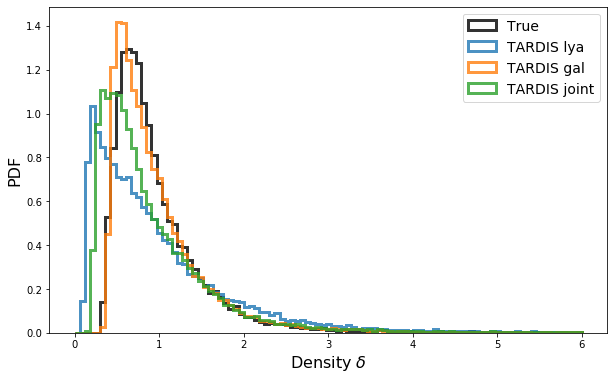

In [129]:
bins = np.linspace(0,6,100)
figure(figsize=(10,6))
sigma=d_los
h_list = {'bins':bins,'histtype':'step','linewidth':3,'alpha':0.8,'density':True}
_=hist(ndimage.gaussian_filter(uni.final_true,sigma).flatten(),label='True',**h_list,color='k')
_=hist(ndimage.gaussian_filter(lya_recon.recon_evolved[0],sigma).flatten(),label='TARDIS lya',**h_list)
_=hist(ndimage.gaussian_filter(gal_recon.recon_evolved[0],sigma).flatten(),label='TARDIS gal',**h_list)
_=hist(ndimage.gaussian_filter(joint_recon.recon_evolved[0],sigma).flatten(),label='TARDIS joint',**h_list)
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
ylabel('PDF',fontsize=16)

In [130]:
sigma=d_los
x = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0]),sigma).flatten()
y1 = ndimage.gaussian_filter(exp(-lya_recon.recon_RSD_tau[0]),sigma).flatten()
y2 = ndimage.gaussian_filter(exp(-gal_recon.recon_RSD_tau[0]),sigma).flatten()
y3 = ndimage.gaussian_filter(exp(-joint_recon.recon_RSD_tau[0]),sigma).flatten()

m1,r1 = linfit(x,y1)
m2,r2 = linfit(x,y2)
m3,r3 = linfit(x,y3)

linx = array([0.4,1.05]).reshape(-1,1)
k1 = ((m1.predict(linx)[1]-m1.predict(linx)[0])/(linx[1]-linx[0]))[0]
k2 = ((m2.predict(linx)[1]-m2.predict(linx)[0])/(linx[1]-linx[0]))[0]
k3 = ((m3.predict(linx)[1]-m3.predict(linx)[0])/(linx[1]-linx[0]))[0]

Text(0.5, 0, '$Flux_{true}$')

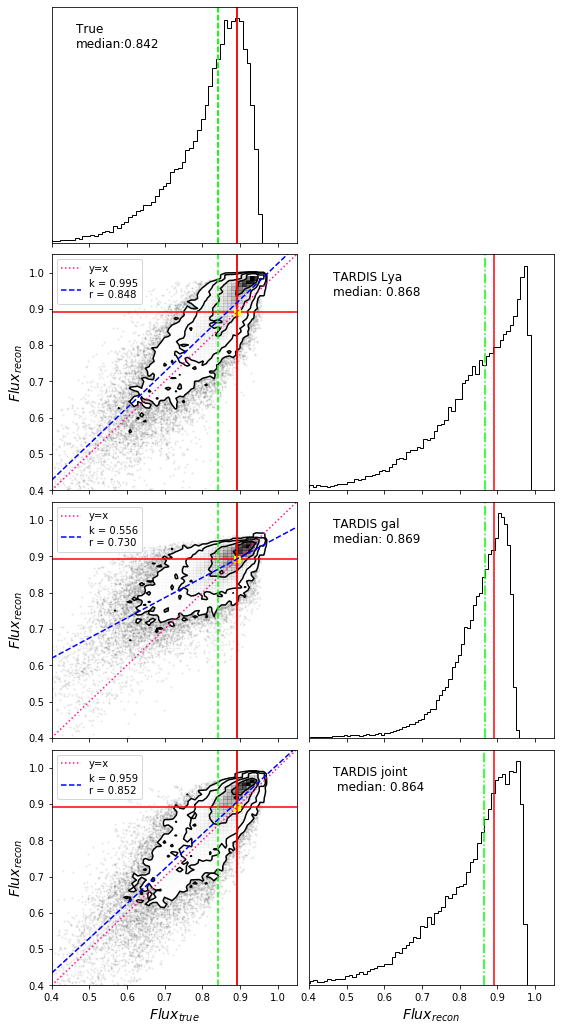

In [132]:
fig,ax = subplots(4,2,figsize=(9,18),sharex='col')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

bins = 80
corner.hist2d(x,y1,ax=ax[1,0],bins=bins)
corner.hist2d(x,y2,ax=ax[2,0],bins=bins)
corner.hist2d(x,y3,ax=ax[3,0],bins=bins)
value,histbin,_= ax[0,0].hist(x,histtype='step',bins=bins,color='k')
_= ax[1,1].hist(y1,histtype='step',bins=bins,color='k')
_= ax[2,1].hist(y2,histtype='step',bins=bins,color='k')
_= ax[3,1].hist(y3,histtype='step',bins=bins,color='k')

a = histbin[where(value==value.max())]+0.5*(histbin[1]-histbin[0])
b=a

q1 = corner.quantile(x,0.5)
q2 = corner.quantile(y1,0.5)
q3 = corner.quantile(y2,0.5)
q4 = corner.quantile(y3,0.5)
q = [q2,q3,q4]

for i in range(4):
    ax[i,1].set_yticks([])
    if i>0:
        ax[i,0].axvline(a,color='red')
        ax[i,0].axhline(b,color='red')
        ax[i,0].set_ylim(0.4,1.05)
        ax[i,0].plot(a,b,'s',c='yellow')
        ax[i,0].set_ylabel(r'$Flux_{recon}$',fontsize=14)
        ax[i,0].plot([0.4,1.05],[0.4,1.05],c='deeppink',linestyle=':',label='y=x')
    for j in range(2):
        ax[i,j].set_xlim(0.4,1.05)
        if j > i:
            ax[i,j].set_frame_on(False)
            ax[i,j].axis('off')
        if (i>0)&(j>0):
            ax[i,j].axvline(a,color='red')
            ax[i,j].axvline(q[i-1],color='lime',linestyle='-.')
        else:
            ax[i,0].axvline(a,color='red')
            ax[i,0].axvline(q1,color='lime',linestyle='--')

ax[1,0].plot(linx,m1.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k1,r1))
ax[1,0].legend()
ax[2,0].plot(linx,m2.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k2,r2))
ax[2,0].legend(loc=2)
ax[3,0].plot(linx,m3.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k3,r3))
ax[3,0].legend(loc=2)

ax[0,0].set_yticks([])
ax[0,0].set_title('True\nmedian:%.3f'%q1,x=0.1,y=0.8,loc='left')
ax[1,1].set_title('TARDIS Lya\nmedian: %.3f'%q2,x=0.1,y=0.8,loc='left')
ax[2,1].set_title('TARDIS gal\nmedian: %.3f'%q3,x=0.1,y=0.8,loc='left')
ax[3,1].set_title('TARDIS joint'+ '\n'+' median: %.3f'%q4,x=0.1,y=0.8,loc='left')
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)
ax[3,1].set_xlabel(r'$Flux_{recon}$',fontsize=14)
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)

With a more realistic S/N from 2 to 10, now TARDIS seems to reconstruct with the best slope, but the mode of flux values still deviates the true one.